<a id='session1'></a>
# Univariate time series

In [1]:
import tensorflow as tf
import numpy as np 
import random
import math
from matplotlib import pyplot as plt
%matplotlib inline
import os
import copy
from data_util import parse_bj_aq_data, generate_training_data_for_seq2seq

In [2]:
# data
bj_aq_data, stations, bj_aq_stations, bj_aq_stations_merged = parse_bj_aq_data()

NaN in PM2.5 is 23459, 6.508615 %
NaN in PM10 is 96175, 26.683406 %
NaN in NO2 is 21720, 6.026135 %
NaN in CO is 46144, 12.802486 %
NaN in O3 is 23732, 6.584358 %
NaN in SO2 is 21664, 6.010598 %
There are 35 air quality stations in Beijing

The stations in Beijing are:
 {'tongzhou_aq', 'xizhimenbei_aq', 'dingling_aq', 'donggaocun_aq', 'miyun_aq', 'yungang_aq', 'wanshouxigong_aq', 'fengtaihuayuan_aq', 'yanqin_aq', 'pinggu_aq', 'liulihe_aq', 'gucheng_aq', 'yufa_aq', 'shunyi_aq', 'nansanhuan_aq', 'mentougou_aq', 'aotizhongxin_aq', 'huairou_aq', 'nongzhanguan_aq', 'zhiwuyuan_aq', 'tiantan_aq', 'dongsihuan_aq', 'yizhuang_aq', 'daxing_aq', 'fangshan_aq', 'yongdingmennei_aq', 'badaling_aq', 'beibuxinqu_aq', 'dongsi_aq', 'qianmen_aq', 'miyunshuiku_aq', 'yongledian_aq', 'guanyuan_aq', 'pingchang_aq', 'wanliu_aq'}


/notebooks/KDD_Cup_2018/data_util.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  bj_aq_station.drop("utc_time", axis=1, inplace=True)
/notebooks/KDD_Cup_2018/data_util.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  bj_aq_station.drop("stationId", axis=1, inplace=True)


In [3]:
ts = bj_aq_stations_merged['pinggu_aq_PM2.5']

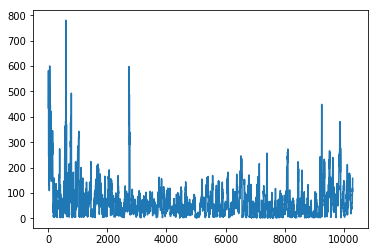

In [4]:
y = ts.values
x = np.linspace(1, len(y), len(y))
plt.plot(x,y);

In [5]:
input_seq, output_seq = generate_training_data_for_seq2seq(ts)
print(input_seq.shape, output_seq.shape)

(10, 120) (10, 48)


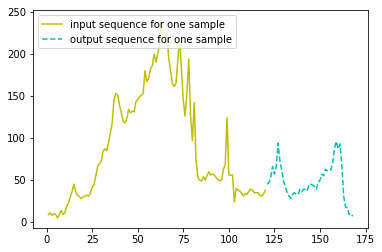

In [6]:
# draw an example of the generated data
x = np.linspace(1, input_seq.shape[1] + output_seq.shape[1], input_seq.shape[1] + output_seq.shape[1])
l1, = plt.plot(x[:input_seq.shape[1]], input_seq[0], 'y', label = 'input sequence for one sample')
l2, = plt.plot(x[input_seq.shape[1]:], output_seq[0], 'c--', label = 'output sequence for one sample')
plt.legend(handles = [l1, l2], loc = 'upper left')
plt.show()

## basic_rnn_seq2seq

In [7]:
from seq2seq_model import * 

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = 120
# length of output signals
output_seq_len = 48 
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = 1
# num of output signals
output_dim = 1
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

## Training process

In [15]:
total_iteractions = 10000
batch_size = 32
KEEP_RATE = 0.5
train_losses = []
val_losses = []

# x = np.linspace(0, 30, 105)
# train_data_x = x[:85]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    for i in range(total_iteractions):
        batch_input, batch_output = generate_training_data_for_seq2seq(ts, batch_size=batch_size, 
                                                                       input_seq_len=input_seq_len, output_seq_len=output_seq_len)
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t].reshape(-1,input_dim) for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t].reshape(-1,output_dim) for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'univariate_ts_model0'))
        
print("Checkpoint saved at: ", save_path)

326948.0
134999.0
231814.0
178220.0
117411.0
223901.0
168820.0
154694.0
167958.0
255246.0
142458.0
70119.3
77233.7
38743.9
212142.0
99453.6
97838.4
120629.0
173418.0
51541.2
169236.0
49356.8
69982.9
152205.0
85458.4
136746.0
30649.1
60912.2
98079.4
81095.5
365092.0
58329.8
67787.5
138734.0
120146.0
64974.9
55428.4
58936.5
193963.0
132457.0
208037.0
322033.0
215716.0
163725.0
132808.0
50197.2
70213.2
173930.0
139400.0
84097.6
34114.9
85390.7
90236.1
66992.8
74919.7
154539.0
209866.0
21341.6
49954.5
112699.0
178566.0
92041.4
87378.8
24987.1
58843.3
32967.1
72896.2
117747.0
100766.0
75953.6
18110.6
31492.6
51453.1
197086.0
12144.9
48646.9
48665.5
57806.6
12140.7
161198.0
208323.0
59452.2
20132.2
96388.0
38763.0
22978.3
88266.4
103993.0
45372.0
97127.8
93668.5
42055.1
108943.0
89394.9
26887.2
51467.6
66744.1
70748.2
65090.2
62964.2
24602.1
29597.0
39606.3
69148.2
35415.9
73607.3
86327.5
65277.1
170589.0
61337.6
87961.7
57123.1
126531.0
55179.5
43384.5
13414.5
95956.1
102142.0
47242.3
29848

36972.1
35764.3
5704.12
61257.2
36008.1
14170.1
5974.93
12590.9
34555.8
29768.2
15272.2
5356.12
23237.8
36799.5
18383.6
8315.19
7802.2
20463.5
16715.7
26096.5
20022.7
39158.6
5666.48
13732.6
39967.7
19875.0
21451.7
10335.0
39306.9
6667.94
16061.1
13004.3
5402.78
24039.9
28575.9
18990.9
17619.5
15074.5
18498.3
19222.6
16064.0
10029.6
51116.4
13787.6
43470.5
12311.2
5934.43
7404.07
36348.6
8546.11
8137.97
24234.6
38671.6
8279.4
7809.74
12628.5
50439.7
6753.98
21849.1
10710.5
20580.6
12169.1
18025.2
5530.12
30790.1
9340.81
34612.7
42924.3
9983.24
7252.65
23348.1
21542.8
8214.44
12470.8
18052.1
10444.1
27412.9
10016.2
5838.82
23611.5
7542.99
8612.3
42499.6
10196.5
31241.1
13796.8
40502.7
6127.45
14869.1
13200.3
6518.63
13115.6
43504.4
65286.7
18714.9
94250.5
6075.88
10184.2
9286.67
7188.08
7056.88
14906.0
7158.4
10976.7
23052.0
11041.6
7774.3
6720.34
8284.6
10251.4
35883.4
10384.4
25253.2
11814.4
38073.3
17596.9
54627.4
5097.72
8179.49
22333.2
23590.4
7397.02
16068.7
31718.2
22173.7
14537.

5377.83
7011.3
7418.21
8205.29
8170.64
32500.6
26022.8
4874.47
14777.7
22645.3
8406.44
29600.5
23015.7
5783.78
7952.75
32122.7
6990.36
34635.7
10282.3
11561.5
6516.02
19386.1
11496.0
5608.07
6383.63
16100.0
5637.19
9850.65
7951.77
8799.42
34323.3
8106.94
13651.1
24959.5
22315.1
11835.7
18806.8
7888.43
14450.2
19990.3
7934.59
7462.01
11173.3
11870.2
11164.5
25888.0
13352.9
7794.34
7067.05
15307.9
12345.7
25904.9
7211.89
8639.1
24017.1
7014.69
4739.56
8142.91
20969.9
23694.9
22184.1
7602.88
8343.69
8102.34
13696.1
5662.83
17223.5
11054.1
8507.14
7038.85
8501.58
24165.1
20118.6
24176.4
15730.9
10166.1
6703.07
9055.85
27806.1
5997.61
8465.38
9276.27
16893.0
12395.0
9170.77
8036.64
11337.6
9682.04
8123.85
9418.34
6540.65
8445.31
29865.7
20587.4
18787.4
11714.3
12306.1
12164.5
6953.45
6811.71
24280.2
11173.4
12542.4
20643.9
8224.71
34251.6
6427.58
7302.55
19787.8
9430.43
7030.6
24314.8
6150.47
8157.48
7529.24
9239.45
17240.6
5399.03
10115.8
8896.04
10909.0
19191.7
7644.93
15661.4
7633.98
106

9059.67
13384.7
7836.83
8289.59
19169.9
21189.1
6087.35
16054.9
7414.84
17476.8
11015.6
7307.83
15394.7
20581.7
9303.83
27326.3
21251.3
7129.46
6484.3
6495.45
7034.73
21300.3
11962.7
8280.39
10925.7
8217.46
20546.9
9072.28
7068.97
8554.23
5587.77
17566.4
18608.8
7845.4
18613.0
8752.16
6380.32
5173.05
7711.94
19340.6
12150.1
4949.64
22002.4
5205.08
6062.94
10446.0
20860.7
15285.5
6495.76
10281.8
8636.71
16241.9
8395.32
7281.47
19955.4
8269.03
6382.21
14888.6
10473.0
6096.8
11085.2
8423.9
8177.15
9303.25
9169.59
17677.9
21104.9
6118.4
6930.98
8512.21
6382.91
12543.5
7122.82
6037.81
8729.35
9523.53
6415.0
8601.62
11832.4
11341.8
8035.61
5440.27
7479.16
17973.8
10547.0
5933.88
10646.1
7659.19
6014.87
18109.7
20254.6
9417.2
31501.4
8204.77
6519.46
5918.89
8582.61
33105.8
5772.41
18241.2
7281.06
7918.6
7431.07
8432.38
4792.99
20599.1
7697.73
9135.38
11244.7
15783.2
10320.3
6178.14
9559.16
10136.0
35613.4
9862.86
8429.09
17552.3
14927.9
19387.0
8692.75
8244.36
22194.7
9302.95
13052.8
22324.5


9746.41
8525.64
8681.91
16363.5
10854.6
8872.86
3661.22
10211.7
12385.9
17078.2
7455.24
12428.4
6431.23
18292.8
23543.8
13658.1
6476.64
9184.63
6708.79
32965.3
25278.5
10574.9
5836.48
10245.3
4839.43
6621.45
30623.5
7085.42
8358.52
9301.78
8387.61
17186.6
5686.06
6455.41
8531.06
14796.0
7138.76
28966.6
8823.73
6471.47
9316.02
13241.9
8875.42
5356.66
8699.66
12997.7
9022.99
6179.57
10701.7
14584.5
6247.92
29754.0
6057.22
9167.56
13725.3
10320.5
11118.4
9647.54
5728.83
8516.47
18946.4
7313.75
8212.86
7605.92
7791.32
20419.5
22334.3
17664.3
7249.51
9764.39
6240.94
28214.7
16172.1
19782.1
7658.28
13114.1
19545.0
22980.4
6492.95
15369.7
15003.1
17721.2
7439.39
8019.49
9208.3
8749.46
9819.69
17124.0
8267.17
18281.9
8443.21
6861.06
5748.2
8489.98
9305.81
12865.7
7698.43
6585.27
7664.25
21090.5
11620.2
18889.3
16241.4
8244.36
8343.61
16369.4
11057.7
7514.45
16071.5
6133.11
6785.13
5970.77
6715.33
8242.9
9026.89
17729.2
7286.11
26249.6
7105.19
10465.4
6239.98
6214.54
6431.86
9939.69
7814.73
882

6287.46
7385.89
9785.17
7168.37
8063.38
8900.24
14377.8
12015.8
23985.7
6141.75
8725.0
7733.57
13463.5
12903.9
5549.39
8046.99
9600.45
7937.25
8271.71
8047.87
14505.6
9555.92
6264.58
8967.94
6679.09
12118.4
13144.9
9911.19
9593.17
11449.4
8068.54
5840.24
7726.67
23416.7
26418.1
6008.62
7831.63
7123.88
14961.6
16305.9
9666.77
9160.74
10902.1
6997.25
7593.45
22747.4
7361.89
15780.6
5964.62
13837.6
17161.0
12427.7
14685.1
12532.4
6442.18
12115.1
15281.5
9667.11
16528.8
5013.96
7586.23
7214.05
6164.24
15528.5
5103.53
11173.7
10267.4
8180.39
10776.9
9125.39
15027.0
14480.0
8872.48
9131.95
6644.69
14942.3
11855.0
6426.9
5734.94
5987.9
11337.3
24565.9
6000.23
10148.4
14473.2
7511.88
15901.1
10321.4
12991.3
23271.3
7779.94
6530.28
5732.14
9187.2
7537.44
6720.01
14646.2
4936.55
10947.1
16409.8
6330.94
7479.8
9264.27
5833.83
21076.3
8505.01
5288.59
7462.92
8862.4
9165.22
8575.08
6481.53
9950.38
15813.2
15899.5
14145.1
10405.9
14352.4
9035.95
17190.7
5659.41
19212.0
8989.3
5416.31
5223.49
26937.2

8289.33
7660.82
10652.5
7838.42
8244.84
11874.2
12672.6
8837.32
7436.33
6788.16
8965.84
7296.55
16916.8
6182.16
8535.0
7176.6
6186.97
6438.34
9014.51
5057.97
10384.5
10041.0
13573.8
13000.7
6924.13
12755.4
6159.28
6833.44
5157.11
11084.5
5497.56
8938.21
7152.47
7344.08
6413.14
13012.6
8657.44
6018.7
8765.74
7339.6
13474.6
7943.98
6014.14
12547.6
13947.9
7764.91
9990.12
7463.33
6490.98
11025.6
9724.46
6808.74
14137.9
7593.39
7307.5
14760.5
13462.4
9339.95
8566.03
7680.94
8084.71
14211.0
9341.68
6584.05
6559.03
7253.28
6181.45
7206.75
8307.23
13328.5
8309.61
13171.7
5893.16
5860.66
7582.27
6464.21
8652.59
7738.73
5858.28
9536.75
15071.7
8574.91
7551.56
8764.72
4990.63
10691.9
6769.71
10562.5
6824.3
9896.59
17924.2
8620.11
11940.7
7819.72
6335.64
11576.8
5857.2
12245.2
14806.3
9972.33
16628.5
9797.0
14279.8
8118.21
6234.83
16531.0
10550.2
7646.43
13616.1
10278.4
7440.48
17716.5
10119.9
5035.82
9263.17
7742.46
8893.82
7928.01
7450.05
9882.26
6579.7
5879.58
17144.8
8254.48
7599.18
5491.33
1

7843.84
5165.05
8033.29
9689.44
20331.6
9425.32
6290.82
11045.5
6832.97
8259.07
13899.0
10631.1
17164.1
16035.7
8183.47
8490.94
7581.72
12869.6
13985.6
9262.26
6477.21
12485.9
8055.05
8267.19
5841.34
7677.19
14824.3
6741.08
6408.75
13206.7
10319.4
17362.3
7328.61
21914.8
10130.8
9227.7
9003.01
8514.5
7197.56
11535.4
8847.85
9279.4
9716.14
6116.34
7825.31
12905.3
8221.49
8994.81
15479.5
9195.09
7040.15
13732.5
7840.56
12444.5
6871.12
13740.1
9336.72
18362.0
8190.35
12713.2
6537.65
4153.78
10868.5
5421.19
9839.26
14459.6
8499.33
8321.27
11862.0
9678.69
6849.1
13117.3
7537.77
13974.4
6777.9
7959.78
5444.73
7610.12
11135.0
7885.01
15912.5
7174.85
6310.97
10796.6
5687.0
7166.61
10216.6
5594.7
6145.63
5485.28
6467.24
5148.57
6296.57
17161.3
6605.53
5722.06
5802.62
6340.36
11170.5
10808.6
11591.3
10726.7
6731.05
6897.35
14779.8
7665.6
5623.39
7472.1
6388.35
5778.95
8389.79
6908.49
6739.72
6914.59
8996.41
8470.93
6180.76
8060.82
4741.09
7525.42
9332.85
12109.2
6044.01
8157.93
6426.65
12052.7
8

9152.63
7414.35
8262.43
8941.34
7654.82
6257.92
6238.63
10500.8
8340.87
5215.73
6518.47
20307.3
7512.92
5833.09
9857.0
8039.01
5369.16
6665.78
14175.6
8965.4
9084.29
16453.4
8959.16
10350.1
8251.63
7672.82
5930.64
7125.36
7238.77
7776.79
9953.52
8396.43
14726.1
17603.7
6567.92
8996.01
10983.9
19421.3
7804.57
7830.18
8079.62
11534.2
6788.4
8341.07
5949.18
15852.7
8516.67
14227.9
14540.1
8404.53
8474.06
7632.05
8669.54
10905.6
8897.92
11229.9
20464.1
7152.66
8779.78
4937.26
9662.75
11276.8
6399.42
15807.7
7097.19
11561.8
13684.1
11725.9
6236.71
6378.2
5654.68
7404.19
11151.8
7162.23
13873.4
8052.41
8475.59
14356.3
14437.2
12620.0
6464.27
11622.6
8144.5
6778.18
8396.61
6065.15
9019.79
10659.4
7521.27
8496.92
9372.66
20931.5
10472.4
7238.6
11680.6
17167.8
5640.49
7071.11
8196.09
9773.87
11060.6
10118.0
7612.62
10624.2
14740.2
10531.2
6704.31
18401.4
13512.3
10596.8
8533.07
7186.63
5844.67
9405.19
7547.29
13154.8
10872.6
8439.46
12981.6
9804.43
5213.18
13400.0
5406.52
15408.1
7880.88
12459.

6959.71
7896.45
10220.7
9688.23
8274.59
8836.36
5704.21
11204.3
7693.91
7080.0
14877.7
6212.12
12405.5
14131.3
5633.0
5824.92
8695.09
11330.8
8509.8
20990.4
6156.58
7129.07
9713.07
12361.5
12394.0
8912.93
8957.7
8199.87
6927.25
10219.8
7684.35
14682.9
7131.33
9260.06
6100.32
6202.1
7210.97
6300.97
5052.68
7434.8
13251.5
7186.56
14563.6
7863.51
11882.8
12229.9
18512.9
6817.0
6651.21
6559.99
6260.56
9258.37
20625.7
17522.1
9863.29
9372.03
6069.76
5147.44
7402.04
8080.19
6593.17
11277.5
8128.62
11801.2
6722.75
10733.9
5972.37
11827.1
9222.53
7072.34
8144.05
9877.01
9249.4
6045.07
6405.91
4718.98
9229.53
5545.69
23336.1
12365.2
16633.6
5846.71
8238.33
7252.65
7512.98
7097.85
6495.43
19579.9
6684.98
6464.08
10278.3
6051.82
7355.07
6186.73
12296.3
8236.63
11186.5
10237.9
8461.12
7167.11
6800.03
7007.17
6411.6
6411.77
7253.86
4858.86
6270.75
11171.0
8606.27
7793.07
6546.01
11290.1
7403.44
7499.49
7856.56
7150.7
6924.03
6343.96
5239.83
5940.81
6517.9
7156.52
7215.15
5275.69
5504.05
7538.21
114

## Inference

In [33]:
# ts should come from dev set
test_input_seq, test_output_seq = generate_training_data_for_seq2seq(ts, batch_size=1, input_seq_len=input_seq_len, output_seq_len=output_seq_len)
test_input_seq = np.squeeze(test_input_seq)
test_output_seq = np.squeeze(test_output_seq)
print(test_input_seq.shape, test_output_seq.shape)

(120,) (48,)


In [34]:
# test_seq_input = true_signal(train_data_x[-15:])

rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('./', 'univariate_ts_model0'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_input_seq[t].reshape(1,1) for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, output_dim]) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = np.concatenate(final_preds, axis = 1)

INFO:tensorflow:Restoring parameters from ./univariate_ts_model0


## Plot  predictions

In [35]:
final_preds = np.squeeze(final_preds)
print(final_preds.shape)

(48,)


In [36]:
x1 = len(test_input_seq)
x2 = len(test_input_seq)+len(test_output_seq)
print(x1, x2)

120 168


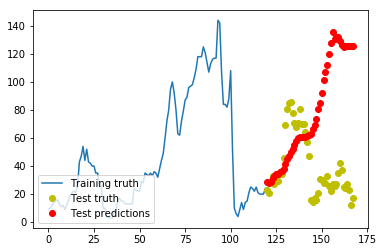

In [37]:
l1, = plt.plot(range(x1), test_input_seq, label = 'Training truth')
l2, = plt.plot(range(x1, x2), test_output_seq, 'yo', label = 'Test truth')
l3, = plt.plot(range(x1, x2), final_preds, 'ro', label = 'Test predictions')
plt.legend(handles = [l1, l2, l3], loc = 'lower left')
plt.show()